## Kaggle's Dogs vs. Cats Redux: Kernels Edition

In [8]:
import sys
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from shutil import copyfile
from random import seed
from random import random
from tqdm import tqdm

from matplotlib import pyplot
from matplotlib.image import imread

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD

from os import listdir, makedirs
from numpy import asarray
from numpy import save
from numpy import load
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import VGG16
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator

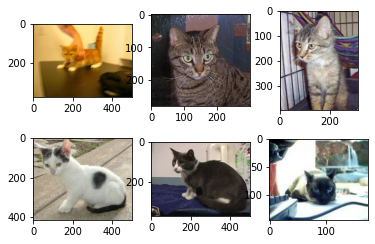

In [11]:
# Plot some photos
folder = 'train/'

for i in range(6):
    pyplot.subplot(230 + 1 + i)
    file_path = folder + 'cat.' + str(i) + '.jpg'
    image = imread(file_path)
    pyplot.imshow(image)
pyplot.show()


### Preprocessing (reshaping)

Here we reshape to make each image the same size of 200 * 200 pixels

In [ ]:
# Photos re
train_path = 'train/'
photos = []
labels = []

for file in listdir(train_path):
    output = 0.0
    if file.startswith('dog'):
        output = 1.0
    
    # get image
    photo = load_img(folder + file, target_size=(200, 200))

    # conv to array
    img_arr = img_to_array(photo)

    # store
    photos.append(photo)
    labels.append(output)

#conv to array
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)

# save reshaped photos
save('dogs_vs_cats_photos.npy', photos)
save('dogs_vs_cats_labels.npy', labels)

In [ ]:
# recheck the shape
# photos = load('dogs_vs_cats_photos.npy')
# labels = load('dogs_vs_cats_labels.npy')
# print(photos.shape, labels.shape)

Next, I will reorganize all photos in the train folder by seperating cat and dog apart as well as keep some of them for validation. 

In [43]:
# organize dataset into a useful structure
# create directories
home_path = 'dataset/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = home_path + subdir + labldir
		makedirs(newdir, exist_ok=True)
		
# seed random number generator
seed(1)
# define ratio of pictures to use for validation -> 25%
val_ratio = 0.25

# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = home_path + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = home_path + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

### Model exploration

Let's first try building a simple CNN model

In [4]:
# define cnn model
def base_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.002, momentum=0.8)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot learning curves
def plot_ln_curve(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_and_test_cnn():
	model = base_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset/train/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory('dataset/test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	plot_ln_curve(history)

In [3]:
# Try a simple cnn model with data augmentation
run_and_test_cnn()

c:\Users\Naphat\anaconda3\envs\env_6420_conda\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


C:\Users\Naphat\AppData\Local\Temp\ipykernel_36912\2605765569.py:42: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
C:\Users\Naphat\AppData\Local\Temp\ipykernel_36912\2605765569.py:45: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)


> 72.600


Here the accuracy is 72.6% which is still low.

Next let's try using a more robust model, VGG model with transfer learning.

In [4]:
def vgg_model():
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.002, momentum=0.8)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model


def run_and_test_vgg():
	model = vgg_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset/train/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory('dataset/test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))

In [5]:
run_and_test_vgg()

c:\Users\Naphat\anaconda3\envs\env_6420_conda\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


C:\Users\Naphat\AppData\Local\Temp\ipykernel_39188\2796680676.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),


Epoch 1/10
293/293 [==============================] - 404s 1s/step - loss: 0.2781 - accuracy: 0.9619 - val_loss: 0.0766 - val_accuracy: 0.9735
Epoch 2/10
293/293 [==============================] - 404s 1s/step - loss: 0.0288 - accuracy: 0.9902 - val_loss: 0.0986 - val_accuracy: 0.9694
Epoch 3/10
293/293 [==============================] - 412s 1s/step - loss: 0.0097 - accuracy: 0.9972 - val_loss: 0.0940 - val_accuracy: 0.9752
Epoch 4/10
293/293 [==============================] - 418s 1s/step - loss: 0.0113 - accuracy: 0.9982 - val_loss: 0.0951 - val_accuracy: 0.9768
Epoch 5/10
293/293 [==============================] - 491s 2s/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.1023 - val_accuracy: 0.9765
Epoch 6/10
293/293 [==============================] - 471s 2s/step - loss: 8.6376e-04 - accuracy: 1.0000 - val_loss: 0.1099 - val_accuracy: 0.9773
Epoch 7/10
293/293 [==============================] - 512s 2s/step - loss: 4.3543e-04 - accuracy: 1.0000 - val_loss: 0.1146 - val_accuracy

C:\Users\Naphat\AppData\Local\Temp\ipykernel_39188\2796680676.py:33: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)


> 97.715


Here the VGG model with transfer learning could achieve a much higher accuracy of 97.715%. So I will continue with this model and start training a final model using all the training photos.

### Training Final model

Before training a model, let reconstruct the folders to be able to use all photos for training

In [ ]:
# create final data folder
dataset_home = 'finalize_data/'
# create label subdirectories
labeldirs = ['dogs/', 'cats/']
for labldir in labeldirs:
    newdir = dataset_home + labldir
    makedirs(newdir, exist_ok=True)
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    if file.startswith('cat'):
        dst = dataset_home + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
      dst = dataset_home + 'dogs/'  + file
      copyfile(src, dst)

In [35]:
# run and save final model
def run_and_save_final():
   model = vgg_model()
   # create data generator
   datagen = ImageDataGenerator(featurewise_center=True)
   # specify imagenet mean values for centering
   datagen.mean = [123.68, 116.779, 103.939]
   train_it = datagen.flow_from_directory('finalize_data/',
   class_mode='binary', batch_size=64, target_size=(224, 224))
   # fit model
   model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=0)
   # save model for reusebility
   model.save('best_model.h5')

In [26]:
run_and_save_final()

58889256/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 25000 images belonging to 2 classes.


<ipython-input-25-4a7f40784b69>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=0)


### Make prediction

In [10]:
# list all the photos
id = []
for photo in listdir('test'):
  if '.jpg' in photo:
    photo_id = photo.split('.')[0]
    id.append(photo_id)

# prediction
model = load_model('best_model.h5')
label = []
for i in tqdm(id):
  path = 'test/' + i + '.jpg'
  img = load_img(path, target_size=(224, 224))
  img = img_to_array(img).reshape(1, 224, 224, 3)
  # center pixel data
  img = img.astype('float32')
  img = img - [123.68, 116.779, 103.939]
  pred = model.predict(img, verbose=0)[0][0]
  label.append(pred)

df = pd.DataFrame({'id':id, 'label':label})
df['id'] = df.id.astype(int)
df = df.sort_values('id').set_index('id')
df.head()

100%|██████████| 12500/12500 [24:56<00:00,  8.35it/s]


,id,label
0,1,1.000000e+00
1,2,1.000000e+00
2,3,1.000000e+00
3,4,1.000000e+00
4,5,3.059880e-34


In [17]:
# Since kaggle use log loss predicting as 0, 1 would be penaltized more
df['label'] = np.clip(df.label,0.0125,0.9875)
df.to_csv('submission.csv')

# Public score of 0.098

### Reference
Part of the solution is inspired by this article https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/